#Importing neccessary Libraries

In [1]:
import os
import torch
import timm
import json
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
from collections import Counter
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import csv

#Configuration

In [2]:
# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 224
subset_size = 50000
num_top_classes = 50
batch_size = 32
epochs = 50
learning_rate = 1e-4
label_smoothing = 0.1
patience = 5

#Transforming Dataset

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#Taking subset of Dataset and dividing into classes

In [4]:
full_dataset = datasets.Places365(root="./places365_data", split='val', small=True, download=True)
simulated_indices = torch.randint(0, len(full_dataset), (subset_size,))
labels = [full_dataset[i][1] for i in simulated_indices]
label_counts = Counter(labels)
top_classes = [cls for cls, _ in label_counts.most_common(num_top_classes)]
class_map = {old: new for new, old in enumerate(top_classes)}
filtered_indices = [i for i in simulated_indices if full_dataset[i][1] in top_classes]

class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, class_map, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.class_map = class_map
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, self.class_map[label]

filtered_dataset = FilteredDataset(full_dataset, filtered_indices, class_map)

100%|██████████| 67.5M/67.5M [00:01<00:00, 34.0MB/s]
100%|██████████| 525M/525M [00:12<00:00, 42.3MB/s]


#Dividing Dataset into Training , Validation and testing

In [5]:
train_size = int(0.7 * len(filtered_dataset))
val_size = int(0.15 * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size - val_size
train_subset, val_subset, test_subset = random_split(
    filtered_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
train_subset.dataset.transform = train_transforms
val_subset.dataset.transform = val_transforms
test_subset.dataset.transform = val_transforms

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

#Hyperparameter Tuning and Training Model

In [6]:
learning_rates = [1e-3, 5e-4, 1e-4]
batch_sizes = [16, 32, 64]

best_hyperparams = {'val_acc': 0.0, 'lr': None, 'bs': None}

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Trying LR={lr}, Batch Size={bs}")

        train_loader = DataLoader(train_subset, batch_size=bs, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_subset, batch_size=bs, shuffle=False, num_workers=2)

        model = models.resnet50(pretrained=True)
        for module in model.modules():
            if isinstance(module, nn.ReLU):
                module.inplace = False
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(model.fc.in_features, num_top_classes)
        )
        model = model.to(device)

        criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        scaler = GradScaler()

        train_loss_history, val_loss_history = [], []
        train_acc_history, val_acc_history = [], []

        best_val_acc = 0
        no_improve_epochs = 0
        for epoch in range(epochs):
            model.train()
            running_loss, correct, total = 0.0, 0, 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            train_loss = running_loss / total
            train_acc = correct / total
            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)

            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            all_preds, all_targets, all_probs = [], [], []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)
                    _, preds = outputs.max(1)
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(labels.cpu().numpy())
                    all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)

            val_loss /= val_total
            val_acc = val_correct / val_total
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)
            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                no_improve_epochs = 0
                torch.save(model.state_dict(), f"best_model_lr{lr}_bs{bs}.pth")
            else:
                no_improve_epochs += 1

            if no_improve_epochs >= patience:
                print("Early stopping triggered.")
                break

        if best_val_acc > best_hyperparams['val_acc']:
            best_hyperparams.update({'val_acc': best_val_acc, 'lr': lr, 'bs': bs})

print(f"\nBest Hyperparameters: LR={best_hyperparams['lr']}, Batch Size={best_hyperparams['bs']}, Val Acc={best_hyperparams['val_acc']:.4f}")


Trying LR=0.001, Batch Size=16


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

Epoch 1: Train Loss=2.8070, Train Acc=0.3322, Val Loss=3.3057, Val Acc=0.3427
Epoch 2: Train Loss=2.1695, Train Acc=0.5249, Val Loss=2.2394, Val Acc=0.5453
Epoch 3: Train Loss=1.8473, Train Acc=0.6363, Val Loss=2.1176, Val Acc=0.6179
Epoch 4: Train Loss=1.5841, Train Acc=0.7326, Val Loss=2.1170, Val Acc=0.6274
Epoch 5: Train Loss=1.3974, Train Acc=0.8009, Val Loss=1.7384, Val Acc=0.7179
Epoch 6: Train Loss=1.2612, Train Acc=0.8559, Val Loss=1.4677, Val Acc=0.8111
Epoch 7: Train Loss=1.1672, Train Acc=0.8938, Val Loss=1.5603, Val Acc=0.7872
Epoch 8: Train Loss=1.1217, Train Acc=0.9088, Val Loss=1.6239, Val Acc=0.7615
Epoch 9: Train Loss=1.0570, Train Acc=0.9310, Val Loss=1.6464, Val Acc=0.7692
Epoch 10: Train Loss=0.9116, Train Acc=0.9799, Val Loss=1.2932, Val Acc=0.8462
Epoch 11: Train Loss=0.8553, Train Acc=0.9919, Val Loss=1.3202, Val Acc=0.8393
Epoch 12: Train Loss=0.8352, Train Acc=0.9938, Val Loss=1.2757, Val Acc=0.8436
Epoch 13: Train Loss=0.7992, Train Acc=0.9987, Val Loss=1.247

#Evaluation

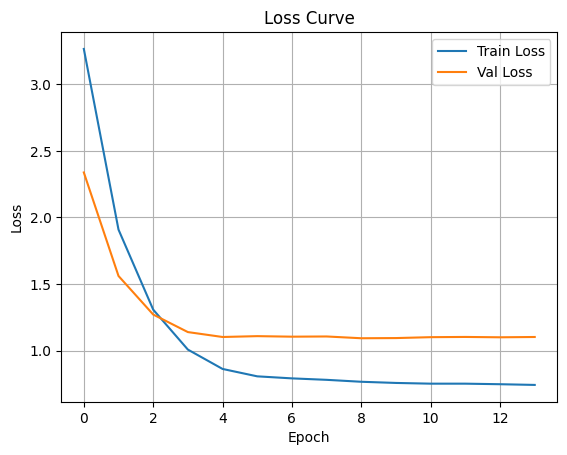

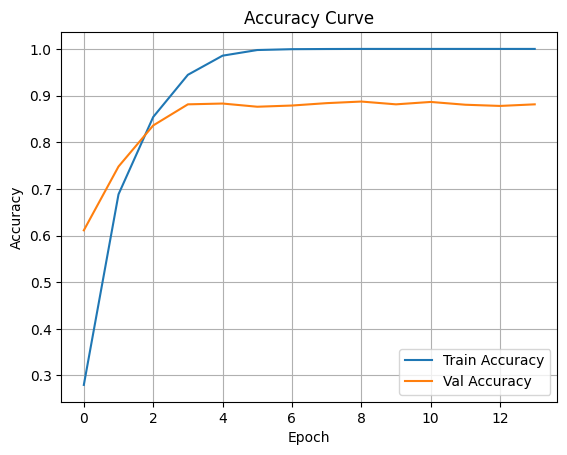


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89        33
           1       0.90      0.95      0.93        20
           2       0.83      1.00      0.91        20
           3       0.82      1.00      0.90        14
           4       0.94      0.74      0.83        23
           5       0.91      0.77      0.83        26
           6       0.88      0.93      0.90        30
           7       0.89      1.00      0.94        16
           8       0.87      0.90      0.89        30
           9       1.00      0.96      0.98        28
          10       0.87      0.87      0.87        23
          11       1.00      1.00      1.00        22
          12       0.96      0.72      0.82        32
          13       0.81      0.71      0.76        24
          14       1.00      0.96      0.98        24
          15       0.89      0.86      0.88        29
          16       0.94      0.91      0.93        34
   

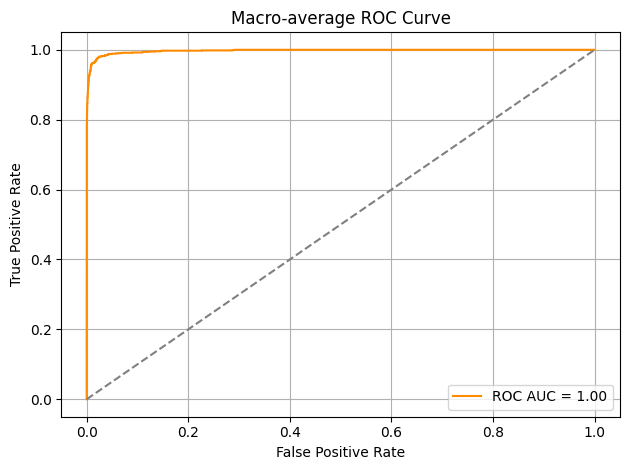

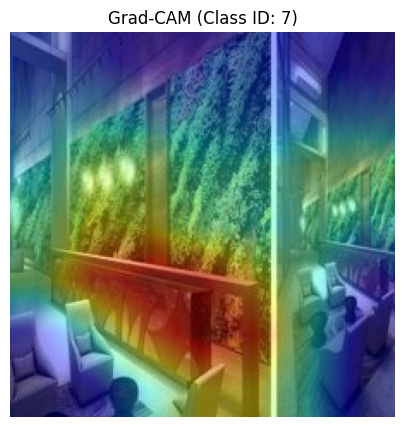


 Final Evaluation on Test Set

Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        25
           1       0.85      0.96      0.90        24
           2       0.92      1.00      0.96        24
           3       0.97      1.00      0.98        29
           4       0.93      0.84      0.88        31
           5       0.77      0.77      0.77        26
           6       0.84      0.91      0.88        23
           7       1.00      0.88      0.94        25
           8       0.96      0.92      0.94        24
           9       1.00      0.87      0.93        23
          10       0.88      0.88      0.88        17
          11       0.95      1.00      0.97        18
          12       0.87      0.57      0.68        23
          13       0.95      0.82      0.88        22
          14       1.00      1.00      1.00        16
          15       0.90      0.64      0.75        28
          16       1.

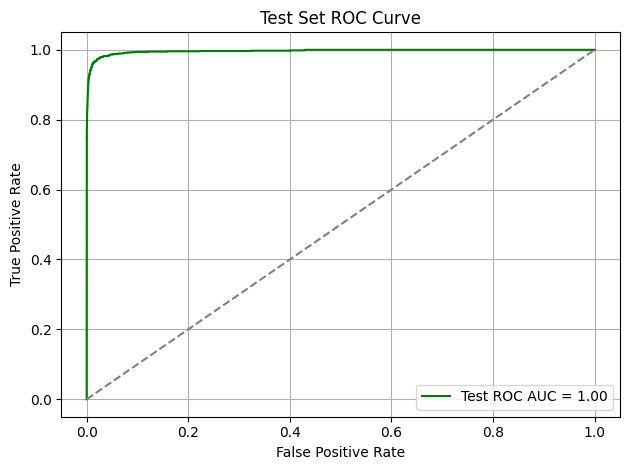

In [9]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize

plt.figure(); plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.title("Loss Curve"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()

plt.figure(); plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Val Accuracy")
plt.title("Accuracy Curve"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()

print("\nClassification Report:")
print(classification_report(all_targets, all_preds))

# ROC Curve
labels_bin = label_binarize(all_targets, classes=np.arange(num_top_classes))
fpr, tpr, _ = roc_curve(labels_bin.ravel(), np.array(all_probs).ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Macro-average ROC Curve")
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# Grad-CAM
sample_img, label = val_subset[0]
def generate_gradcam(model, image_tensor, target_class=None):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)
    target_layer = model.layer4
    activations, gradients = [], []
    def forward_hook(m, inp, out): activations.append(out)
    def backward_hook(m, grad_in, grad_out): gradients.append(grad_out[0])
    h1 = target_layer.register_forward_hook(forward_hook)
    h2 = target_layer.register_full_backward_hook(backward_hook)
    output = model(image_tensor)
    target_class = output.argmax().item() if target_class is None else target_class
    loss = output[0, target_class]; model.zero_grad(); loss.backward()
    h1.remove(); h2.remove()
    act, grad = activations[0], gradients[0]
    weights = grad.mean(dim=[2, 3], keepdim=True)
    cam = (weights * act).sum(dim=1).squeeze().relu()
    cam -= cam.min(); cam /= cam.max(); return cam.detach().cpu().numpy(), target_class

cam, cls_id = generate_gradcam(model, sample_img, target_class=label)
img_np = sample_img.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img_np = np.clip(img_np, 0, 1)
cam_resized = F.interpolate(torch.tensor(cam).unsqueeze(0).unsqueeze(0), size=img_np.shape[:2], mode='bilinear')[0,0].numpy()
plt.figure(figsize=(5,5))
plt.imshow(img_np)
plt.imshow(cam_resized, cmap='jet', alpha=0.4)
plt.title(f"Grad-CAM (Class ID: {cls_id})")
plt.axis('off')
plt.show()

print("\n Final Evaluation on Test Set")
# model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_preds, test_targets, test_probs = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = probs.max(1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

print("\nTest Classification Report:")
print(classification_report(test_targets, test_preds))

# ROC for test set
labels_bin = label_binarize(test_targets, classes=np.arange(num_top_classes))
fpr, tpr, _ = roc_curve(labels_bin.ravel(), np.array(test_probs).ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"Test ROC AUC = {roc_auc:.2f}", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Test Set ROC Curve")
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()
